In [1]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import xarray as xr
import cmocean as cm
from collections import OrderedDict
import cftime
import glob
import dask
import os

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

# from dask.distributed import Client, LocalCluster
# from cosima_cookbook import distributed as ccd

In [2]:
#client = Client(n_workers=4)
# >> dask-scheduler
# >> dask-worker tcp://10.0.64.9:8786 --memory-limit 4e9 --nprocs 6 --nthreads 1 --local-directory /local/g40/amh157
#client = Client('tcp://10.0.64.9:8786', local_dir='/local/g40/amh157')
# client = Client(n_workers=48)
# client = Client(LocalCluster(n_workers=48, threads_per_worker=1, local_directory=os.environ["PBS_JOBFS"]))
# client
import climtas.nci
climtas.nci.GadiClient()

Client Scheduler: tcp://127.0.0.1:36861 Dashboard: /proxy/8787/status,Cluster Workers: 1 Cores: 1 Memory: 103.08 GB


In [3]:
cyc2_session = cc.database.create_session('cyc2_database_cj50.db')
cyc2_dir_list = glob.glob('/g/data/cj50/access-om2/raw-output/access-om2-01/01deg_jra55v140_iaf_cycle2')
cc.database.build_index(cyc2_dir_list, cyc2_session, update=True)

Indexing experiment: 01deg_jra55v140_iaf_cycle2


100%|██████████| 25198/25198 [1:58:14<00:00,  3.55it/s]  


25198

In [4]:
# session = cc.database.create_session('/g/data/ik11/databases/iaf_jrav140.db')
session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')

In [5]:
exptdict = OrderedDict([
#     ('01deg_RYF9091',   {'expt':'01deg_jra55v13_ryf9091','dir':'access-om2-01'}),
    ('01deg_IAF',  {'expt':'01deg_jra55v140_iaf','dir':'access-om2-01', 'session': session}),
    ('01deg_IAF_cyc2',  {'expt':'01deg_jra55v140_iaf_cycle2','dir':'access-om2-01', 'session': cyc2_session})
                        ])

In [6]:
cc.querying.get_experiments(cyc2_session)

,experiment,ncfiles
0,01deg_jra55v140_iaf_cycle2,25198


## Just checking the final data for each expt.

In [7]:
for ekey, e in exptdict.items():
    variable = 'temp_global_ave'
    expt = e['expt']
    var = cc.querying.getvar(expt,variable,e['session'])
#     print(repr(var['time'].min()) + ' to ' + repr(var['time'].max()))
    start_year = np.int(np.ceil(cftime.date2num(var['time'].min(),'days since 0001-01-01','noleap')/365))
    end_year = np.int(np.ceil(cftime.date2num(var['time'].max(),'days since 0001-01-01','noleap')/365))
    print(expt+' goes from %d to (at least some of) %d'% (start_year, end_year))

01deg_jra55v140_iaf goes from 1958 to (at least some of) 2018
01deg_jra55v140_iaf_cycle2 goes from 1958 to (at least some of) 2018


In [8]:
    
end_time = '2018-12-31'

# end_time = '1976-12-31'

# end_time = '1991-12-31'

# end_time = '2012-12-31'

# end_time = '2013-12-31'

print(' Setting end_time to',end_time)

 Setting end_time to 2018-12-31


## compute_delayed
from Angus: 
https://arccss.slack.com/archives/C6PP0GU9Y/p1595293252452600?thread_ts=1594265206.425100&cid=C6PP0GU9Y

In [9]:
def compute_delayed(ds):
    from itertools import product
    import numpy as np
    slices = []
    for chunks in ds.chunks:
        L = [0] + list(np.cumsum(chunks))
        slices.append([slice(*s) for s in zip(L[:-1], L[1:])])
    indices = list(product(*slices))
    out = xr.zeros_like(ds).load()
    delayed = ds.data.to_delayed()
    for i, d in zip(indices, delayed):
        out.__setitem__(i, d.compute())
    return out

## Scalar diagnostics

In [10]:
def plot_timeseries(variable,end_time):
    plt.figure(figsize=(10,5))
    for ekey, e in exptdict.items():
        expt = e['expt']
        var = cc.querying.getvar(expt,variable,e['session'],end_time=end_time)
        var.resample(time='Y').mean().plot(label=ekey)
    plt.title(variable)
    plt.legend()
    return

### Global Average Temperature

CPU times: user 2min 56s, sys: 10.3 s, total: 3min 7s
Wall time: 9min 29s


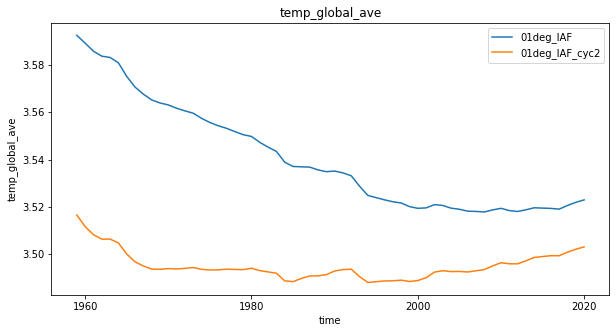

In [11]:
%%time
plot_timeseries('temp_global_ave',end_time)

### Global Average Salinity

CPU times: user 3min 43s, sys: 13.7 s, total: 3min 57s
Wall time: 15min 7s


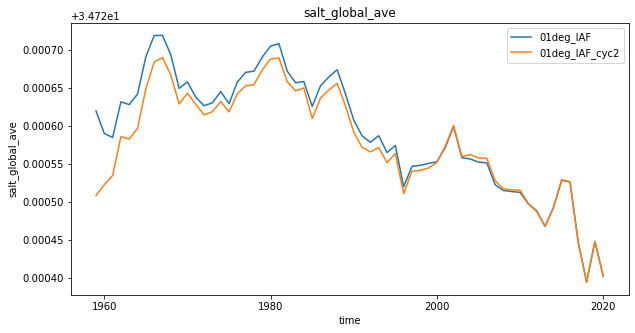

In [12]:
%%time
plot_timeseries('salt_global_ave',end_time)

### Surface Temperature

distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

CPU times: user 3min 34s, sys: 20.7 s, total: 3min 55s
Wall time: 16min 15s


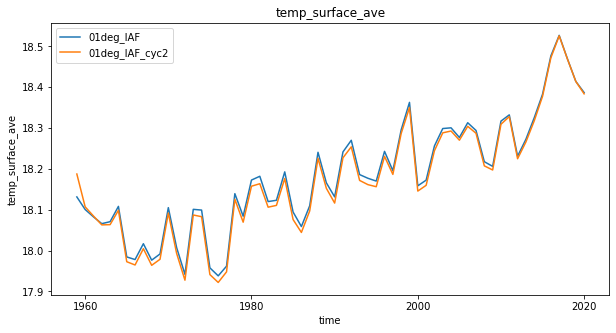

In [13]:
%%time
plot_timeseries('temp_surface_ave',end_time)

### Surface Salinity

distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

CPU times: user 3min 25s, sys: 15.1 s, total: 3min 40s
Wall time: 12min 56s


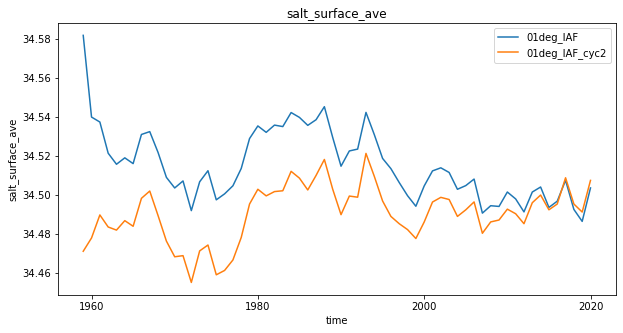

In [14]:
%%time
plot_timeseries('salt_surface_ave',end_time)

### Total Kinetic Energy

distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

CPU times: user 3min 3s, sys: 9.39 s, total: 3min 13s
Wall time: 8min 48s


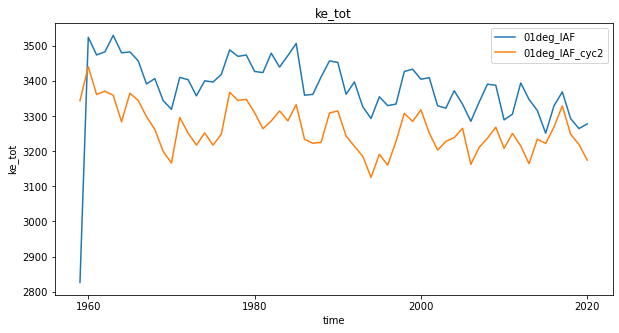

distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)


In [15]:
%%time
plot_timeseries('ke_tot',end_time)

## Area-Averaged Tracer Diagnostics

In [16]:
def plot_upper_ocean(variable,end_time):
    plt.figure(figsize=(10,5))
    zlevel = 1000
    for ekey in exptdict.keys():
        expt = exptdict[ekey]['expt']
        print(expt)
        try:
            var = cc.querying.getvar(expt,variable,session,ncfile='ocean.nc',end_time=end_time,lock=False)
        except:
            var = cc.querying.getvar(expt,variable,session,ncfile='ocean-3d-'+variable+'-1-monthly-mean-ym%',end_time=end_time,lock=False)
#         varmean = var.sel(st_ocean = slice(0,zlevel)).mean('st_ocean').mean('yt_ocean').mean('xt_ocean').resample(time='Y').mean().chunk({'time': 20})
# #         varmeanopt = dask.optimize(varmean.data)[0]
# #         varmeanopt.compute()
#         cvarmean = ccd.compute_by_block(varmean)
#         cvarmean.plot(label=ekey)
# from Angus: https://arccss.slack.com/archives/C6PP0GU9Y/p1595293252452600?thread_ts=1594265206.425100&cid=C6PP0GU9Y
        tmp = compute_delayed(var.sel(st_ocean=slice(0, zlevel)).mean(["st_ocean", "yt_ocean", "xt_ocean"]).chunk({"time": 30}))
        tmp.compute()
        varmean = tmp.resample(time='Y').mean()
        varmean.plot(label=ekey)
    plt.legend()
    plt.title('Upper Ocean (< '+str(zlevel)+') '+variable)

### Upper Ocean Temperature/Salinity

In [ ]:
%%time
plot_upper_ocean('temp',end_time)

01deg_jra55v140_iaf


distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

In [ ]:
%%time
plot_upper_ocean('salt',end_time)

### Deep Ocean Temperature/Salinity

In [15]:
def plot_lower_ocean(variable,end_time):
    plt.figure(figsize=(10,5))
    zlevel = 3000
    for ekey in exptdict.keys():
        expt = exptdict[ekey]['expt']
        print(expt)
        try:
            var = cc.querying.getvar(expt,variable,session,ncfile='ocean.nc',end_time=end_time,lock=False)
        except:
            var = cc.querying.getvar(expt,variable,session,ncfile='ocean-3d-'+variable+'-1-monthly-mean-ym%',end_time=end_time,lock=False)
#         varmean = var.sel(st_ocean = slice(zlevel,None)).mean('st_ocean').mean('yt_ocean').mean('xt_ocean').resample(time='Y').mean()
# from Angus: https://arccss.slack.com/archives/C6PP0GU9Y/p1595293252452600?thread_ts=1594265206.425100&cid=C6PP0GU9Y
        tmp = compute_delayed(var.sel(st_ocean=slice(0, zlevel)).mean(["st_ocean", "yt_ocean", "xt_ocean"]).chunk({"time": 30}))
        tmp.compute()
        varmean = tmp.resample(time='Y').mean()
        varmean.plot(label=ekey)
    plt.legend()
    plt.title('Deep Ocean (> '+str(zlevel)+') '+variable)
    

In [ ]:
%%time
plot_lower_ocean('temp',end_time)

In [ ]:
%%time
plot_lower_ocean('salt',end_time)

## Circulation Diagnostics

### Drake Passage Transport

In [ ]:
%%time

xmin=-69.9
ymin=-71.6
ymax=-51.0

variable='tx_trans_int_z'
plt.figure(figsize=(10,5))
for ekey in exptdict.keys():
    expt = exptdict[ekey]['expt']
    print(expt)
    var = cc.querying.getvar(expt,variable,session,end_time=end_time)
    DP = var.sel(xu_ocean=xmin, method='nearest').sel(yt_ocean=slice(ymin, ymax)).sum('yt_ocean').resample(time='Y').mean()/1e6/1036
    DP.plot(label=ekey)

plt.legend()
plt.title("ACC Transport")

### AABW overturning circulation @ 55°S

**To Do** - add GM to this.

In [ ]:
%%time
latitude=-55
plt.figure(figsize=(10,5))
variable='ty_trans_rho'
for ekey in exptdict.keys():
    expt = exptdict[ekey]['expt']
    print(expt)
    var = cc.querying.getvar(expt,variable,session,end_time=end_time)
    psi_aabw = var.sum('grid_xt_ocean').sel(method='Nearest',grid_yu_ocean=latitude)*1.0e-9
    psi_aabw_sum = psi_aabw.cumsum('potrho') - psi_aabw.sum('potrho')
    psi_aabw_sum = -psi_aabw_sum.sel(potrho=slice(1036.2,None)).min('potrho').resample(time='Y').mean()
    psi_aabw_sum.plot(label=ekey)
plt.legend()
plt.title('AABW Cell')

### AMOC Overturning @ 26°N

In [ ]:
%%time
plt.figure(figsize=(10,5))
variable='ty_trans_rho'
for ekey in exptdict.keys():
    expt = exptdict[ekey]['expt']
    print(expt)
    var = cc.querying.getvar(expt,variable,session,end_time=end_time)
    psi_amoc = var.sel(grid_xt_ocean=slice(-103,-5)).sum('grid_xt_ocean').sel(method='Nearest',grid_yu_ocean=26)*1.0e-9
    psi_amoc_sum = psi_amoc.cumsum('potrho') - psi_amoc.sum('potrho')
    psi_amoc_sum = psi_amoc_sum.sel(potrho=slice(1035.5,None)).max('potrho').resample(time='Y').mean()
    psi_amoc_sum.plot(label=ekey)
plt.legend()
plt.title('AMOC Cell')

## Global Overturning Streamfunction

In [ ]:
def plot_psi(psi_avg, clev=np.arange(-25,25,2)):
    plt.figure(figsize=(12,8))
    p1 = plt.contourf(psi_avg.grid_yu_ocean, 
                 psi_avg.potrho, 
                 psi_avg, 
                 cmap=cm.cm.delta,levels=clev,extend='both')
    plt.contour(psi_avg.grid_yu_ocean, 
                psi_avg.potrho, 
                psi_avg, levels=clev, colors='k', linewidths=0.25)
    plt.contour(psi_avg.grid_yu_ocean,
                psi_avg.potrho, psi_avg,
                levels=[0.0,], colors='k', linewidths=0.5)
    plt.gca().invert_yaxis()
    
    plt.ylim((1037.5,1034))
    plt.ylabel('Potential Density (kg m$^{-3}$)')
    plt.xlabel('Latitude ($^\circ$N)')
    plt.xlim([-75,85])
    
    return p1

In [ ]:
psi = cc.querying.getvar('01deg_jra55v140_iaf','ty_trans_rho',session,end_time='2067-01-01')
psi = psi.mean('time').sum('grid_xt_ocean')*1.0e-9
psi_avg = psi.cumsum('potrho') -  psi.sum('potrho')
psi_avg.load()
plot_psi(psi_avg)

In [ ]:
psi = cc.querying.getvar('01deg_jra55v13_ryf9091','ty_trans_rho',session,start_time='2058-01-01', end_time='2067-01-01')
psi = psi.mean('time').sum('grid_xt_ocean')*1.0e-9
psi_avg = psi.cumsum('potrho') -  psi.sum('potrho')
psi_avg.load()
plot_psi(psi_avg)

### Ice Area (in both hemispheres)

In [ ]:
variable='aice_m'
fig,ax = plt.subplots(1,2,figsize=(14,6))
for ekey in exptdict.keys():
    expt = exptdict[ekey]['expt']
    var = cc.querying.getvar(expt,variable,session,start_time='1950-01-01',end_time=end_time,coords="all")
    area_t = cc.querying.getvar(expt, 'area_t',session,n=1)
    var.coords['ni'] = area_t['xt_ocean'].values
    var.coords['nj'] = area_t['yt_ocean'].values
    var = var.rename(({'ni':'xt_ocean', 'nj':'yt_ocean'}))
    area = var*area_t
    area_zonalsum = area.sum('xt_ocean')
    NH_area = area_zonalsum.sel(yt_ocean=slice(45, 90)).sum('yt_ocean').load()
    NH_area.plot(ax=ax[0],label=ekey)
    SH_area = area_zonalsum.sel(yt_ocean=slice(-90, -45)).sum('yt_ocean').load()
    SH_area.plot(ax=ax[1],label=ekey)
plt.legend()
ax[0].set_title('Arctic')
ax[1].set_title('Southern Ocean')

### Ice volume (in both hemispheres)

In [ ]:
variable='vicen_m'
fig,ax = plt.subplots(1,2,figsize=(14,6))
for ekey in exptdict.keys():
    expt = exptdict[ekey]['expt']
    var = cc.querying.getvar(expt,variable,session,start_time='1950-01-01',end_time=end_time,coords="all")
    area_t = cc.querying.getvar(expt, 'area_t',session,n=1)
    var.coords['ni'] = area_t['xt_ocean'].values
    var.coords['nj'] = area_t['yt_ocean'].values
    var = var.rename(({'ni':'xt_ocean', 'nj':'yt_ocean'}))
    vol = var*area_t
    vol_zonalsum = vol.sum('xt_ocean').sum('nc')
    NH_vol = vol_zonalsum.sel(yt_ocean=slice(45, 90)).sum('yt_ocean').load()
    NH_vol.plot(ax=ax[0],label=ekey)
    SH_vol = vol_zonalsum.sel(yt_ocean=slice(-90, -45)).sum('yt_ocean').load()
    SH_vol.plot(ax=ax[1],label=ekey)
plt.legend()
ax[0].set_title('Arctic')
ax[1].set_title('Southern Ocean')